In [3]:
spark

In [4]:
import boto3
import datetime
import pandas as pd
from hops import hdfs
from pyspark.sql import SparkSession
from pyspark.sql import Row

In [5]:
bucket_name = "iiaweb-s3-io-practice-bucket"

s3_resource = boto3.resource('s3', region_name='us-east-2')
bucket = s3_resource.Bucket(bucket_name)

Inspect bucket contents

In [6]:
contents = list(bucket.objects.all())
zipped_filekeys = [object.key for object in contents if '.gzip' in object.key]
print(len(zipped_filekeys))

59481

In [7]:
bucket_name = 'iiaweb-s3-io-practice-bucket'
key = '652/1/652200101092009.gzip'
print(bucket_name, key)

iiaweb-s3-io-practice-bucket 652/1/652200101092009.gzip

In [8]:
s3_client = boto3.client('s3')

# key = zipped_filekeys[0]
obj = s3_client.get_object(Bucket= bucket_name, Key= key)


print("Loading file: ", key)
pandas_df = pd.read_csv(obj['Body'], compression='gzip')
pandas_df.head()

Loading file:  652/1/652200101092009.gzip
             timestamp  FPAC  BLAC  CTAC  ...  EHRS_3  EHRS_2  ESN_1  ESN_2
0  2001-01-09 20:09:00     0     0     0  ...    6359    5633   7882   7833
1  2001-01-09 20:09:01     0     0     0  ...    6359    5633   7882   7833
2  2001-01-09 20:09:02     0     0     0  ...    6359    5633   7882   7833
3  2001-01-09 20:09:03     0     0     0  ...    6359    5633   7882   7833
4  2001-01-09 20:09:04     0     0     0  ...    6359    5633   7882   7833

[5 rows x 187 columns]

In [9]:
len(pandas_df)

3943

## Loading a Zipped CSV From S3 to Spark 

In [10]:
#Initialize a Master DF with the first file
started = datetime.datetime.now()

s3_client = boto3.client('s3')

# key = zipped_filekeys[0]

obj = s3_client.get_object(Bucket= bucket_name, Key= key)
df = spark.createDataFrame(pd.read_csv(obj['Body'], compression='gzip'))

finished = datetime.datetime.now()
elapsed = finished - started
print('Operation took: ', elapsed)

Operation took:  0:00:08.682068

In [11]:
df.show(5)

+-------------------+----+----+----+---+---+-----+-----+-----+-----+---+---+---+----+---+----+---+---+----+---+---+----+----+----+------+-------------+-----------------+-------------------+-------------------+----+----+---------+----+----+----+----+----+----+----+---+----+---+----+---+------------------+-------------------+---+-----------------+-------+----+---+-----+---------+----+----+----+----+-----+----+----+----+------+-----+--------------------+-------------------+-------+----+----+----+----+-----+------------------+------------------+------------------+--------+----------+-------+----+------+-----------------+-------------+---+---+----+-------------------+----+----+----+----+----+----+---+----+----+----+----+-----+-----+---------+---+-------------------+------+-----+-----+------+-----------------+-----------------+----+----+----+----+----+---+------+-----+----+---+----+----+----+----+----+-----+-----+--------------------+---+---------+-------------+-----------------+------------

## Hive

In [23]:
from hops import hdfs as hopsfs
PROJECT_NAME = hopsfs.project_name()

In [24]:
PROJECT_NAME

'MattTest'

## Show Tables

In [25]:
spark.sql("show tables").show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
|matttest|nasa_dashlink|      false|
+--------+-------------+-----------+

## Create Initial Table

In order to save to an HDFS Hive Table, you must first use the command `spark.sql("USE [project_name])`

In [12]:
spark.sql("USE MattTest")

DataFrame[]

In [13]:
df.write.format("ORC").mode("overwrite").saveAsTable("NASA_Dashlink")

## Preview Data

In [14]:
spark.sql("Select count(*) from nasa_dashlink").show()

+--------+
|count(1)|
+--------+
|    3943|
+--------+

In [15]:
spark.sql("Select * from nasa_dashlink limit 2").show()

+-------------------+----+----+----+---+---+-----+-----+-----+-----+---+---+---+----+---+----+---+---+----+---+---+----+----+----+------+-------------+-----------------+-------------------+-------------------+----+----+------+----+----+----+----+----+----+----+---+----+---+----+---+------------------+-------------------+---+-----------------+-------+----+---+-----+---------+----+----+----+----+-----+----+----+----+------+-----+--------------------+-------------------+-------+----+----+----+----+-----+------------------+------------------+------------------+--------+----------+-------+----+------+-----------------+-------------+---+---+----+-------------------+----+----+----+----+----+----+---+----+----+----+----+-----+-----+---------+---+-------------------+------+-----+-----+------+-----------------+-----------------+----+----+----+----+----+---+------+-----+----+---+----+----+----+----+----+-----+-----+--------------------+---+---------+-------------+-----------------+---------------

## Plotting

In order to plot results, you must first export the data you wish to visualize to the local context using the command `%%spark -o df` (where df is the object you wish to export).
From there, all cells run with the magic command `%%local` will be executed in the local environment, allowing you to plot results inline.

In [16]:
%%spark -o df

In [17]:
%%local
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df.head()

Output()

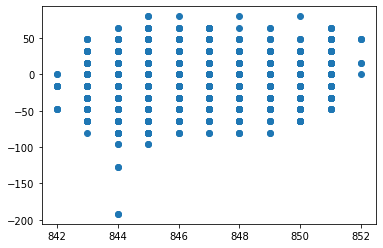

In [23]:
%%local

plt.scatter(df['ALT'], df['ALTR'])